<a href="https://colab.research.google.com/github/EgorDudyrev/PeaViner/blob/main/Myocard%20case%20with%20PeaViner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/EgorDudyrev/PeaViner
!pip install bitarray

  Cloning https://github.com/EgorDudyrev/PeaViner to /tmp/pip-req-build-0yd19_z4
  Running command git clone --filter=blob:none --quiet https://github.com/EgorDudyrev/PeaViner /tmp/pip-req-build-0yd19_z4
  Resolved https://github.com/EgorDudyrev/PeaViner to commit fc86552174b06b53ed47bae68825c052e50c79de
  Preparing metadata (setup.py) ... done


# Run PeaClassifier

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

df = pd.read_csv('https://raw.githubusercontent.com/EgorDudyrev/PeaViner/main/data/Myocardial_infarction_complications.csv', index_col=0)
df = df.replace('?', -1).astype(float)

x_feats = [f for f in df if not f.startswith('Outcome')]
y_feats = df.drop(x_feats, axis=1).columns
y_feat = df[y_feats[(df[y_feats].nunique()==2)]].mean().idxmax()
print(f"#train features: {len(x_feats)};\t Target feature: '{y_feat}'")

X, y = df[x_feats].values.astype(float), df[y_feat].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(f"train size: {len(X_train)}; test size: {len(X_test)}")

#train features: 111;	 Target feature: 'Outcome_121. Chronic heart failure (ZSN)'
train size: 1360; test size: 340


In [ ]:
%%time
from peaviner import PeaClassifier

pc = PeaClassifier()
pc.fit(X_train, y_train, use_tqdm=True)
pc_scores = f1_score(y_train, pc.predict(X_train)), f1_score(y_test, pc.predict(X_test))
print(f"Train F1 score: {pc_scores[0]:.2f}, Test F1 score: {pc_scores[1]:.2f}")

Generate p's:   0%|          | 0/111 [00:00<?, ?it/s]

Compute stats for pq, p|q:   0%|          | 0/1241100 [00:00<?, ?it/s]

Iter pqr:   0%|          | 0/981 [00:00<?, ?it/s]

Iter pq|r:   0%|          | 0/978 [00:00<?, ?it/s]

Iter (p|q)r:   0%|          | 0/1574 [00:00<?, ?it/s]

Iter p|q|r:   0%|          | 0/923 [00:00<?, ?it/s]

Train F1 score: 0.47, Test F1 score: 0.42
CPU times: user 9min 34s, sys: 3.5 s, total: 9min 37s
Wall time: 10min 12s


In [ ]:
print(pc.explain(x_feats).replace(' OR ', '\nOR '))#.replace(' AND ', '\nAND '))

2. Age (AGE) >= 53.0 AND 88. Serum AsAT content (AST_BLOOD) (IU/L) >= 0.26
OR 12. Presence of chronic Heart failure (HF) in the anamnesis (ZSN_A) >= 1.0


The runtime of the algorithm mostly depends on the number of basic ``atomic'' binary attributes obtained from the data.

The number of rows in the data should not affect the algorithm much.

In [ ]:
len(pc.get_atomic_premises(X_train))

1576

# Comparison with Tree-based classifiers

## Look at the current classifiers landscape

In [ ]:
!pip install catboost --quiet
!pip install xgboost --quiet

In [ ]:
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()

cb_leaves, cb_scores_cv = [], []
for train, test in tqdm(kf.split(X, y), total=kf.n_splits):
    cb.fit(X[train], y[train], verbose=False)
    scores = f1_score(y[train], cb.predict(X[train])), f1_score(y[test], cb.predict(X[test]))
    cb_scores_cv.append(scores)
    cb_leaves.append(cb.get_tree_leaf_counts().sum())

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb_leaves, xgb_scores_cv = [], []
for train, test in tqdm(kf.split(X, y), total=kf.n_splits):
    xgb.fit(X[train], y[train])
    scores = f1_score(y[train], xgb.predict(X[train])), f1_score(y[test], xgb.predict(X[test]))
    xgb_scores_cv.append(scores)
    xgb_leaves.append((xgb.get_booster().trees_to_dataframe()['Feature']=='Leaf').sum())

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

dt_leaves, dt_scores_cv = [], []
for train, test in tqdm(kf.split(X, y), total=kf.n_splits):
    dtree.fit(X[train], y[train])
    scores = f1_score(y[train], dtree.predict(X[train])), f1_score(y[test], dtree.predict(X[test]))
    dt_scores_cv.append(scores)
    dt_leaves.append(dtree.get_n_leaves())

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_small = DecisionTreeClassifier(max_depth=3)

dt_sm_leaves, dt_sm_scores_cv = [], []
for train, test in tqdm(kf.split(X, y), total=kf.n_splits):
    dtree_small.fit(X[train], y[train])
    scores = f1_score(y[train], dtree_small.predict(X[train])), f1_score(y[test], dtree_small.predict(X[test]))
    dt_sm_scores_cv.append(scores)
    dt_sm_leaves.append(dtree_small.get_n_leaves())

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
models_data = []  # pd.DataFrame(columns=['Train F1 score', 'Test F1 score', '#Leaves', 'Fold id'])
for (model_name, scores_cv, leaves) in [
    ('CatBoost', cb_scores_cv, cb_leaves),
    ('XGBoost', xgb_scores_cv, xgb_leaves),
    ('Decision Tree', dt_scores_cv, dt_leaves),
    ('DT sm', dt_sm_scores_cv, dt_sm_leaves)
]:
    for fold_id, ((train, test), n_leaves) in enumerate(zip(scores_cv, leaves)):
        models_data.append({
            'model name': model_name, 'fold id': fold_id,
            'Train F1 score': train, 'Test F1 score': test,
            '#Leaves': n_leaves
        })

models_data = pd.DataFrame(models_data)
models_data.head()

,model name,fold id,Train F1 score,Test F1 score,#Leaves
0,CatBoost,0,0.779923,0.380952,63374
1,CatBoost,1,0.815642,0.400000,63276
2,CatBoost,2,0.805195,0.423077,63272
3,CatBoost,3,0.816327,0.392857,63224
4,CatBoost,4,0.806202,0.389831,63180


Text(0.5, 1.0, 'Accuracy Interpretability "Tradeoff"')

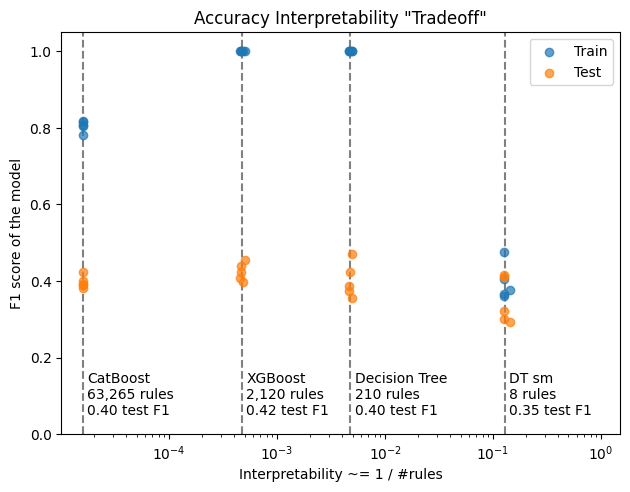

In [ ]:
import matplotlib.pyplot as plt

for ds_part in ['Train', 'Test']:
    y_axis = f'{ds_part} F1 score'
    plt.scatter(1/models_data['#Leaves'], models_data[y_axis], label=ds_part, alpha=0.7)
plt.legend()

avgs = models_data.groupby('model name')['#Leaves'].mean()
avg_f1 = models_data.groupby('model name')['Test F1 score'].mean()
for model_name, n_leaves in avgs.items():
    plt.axvline(1/n_leaves, zorder=0, linestyle='--', color='gray',)
    plt.text(1/n_leaves*1.1, 0.05, '\n'.join([model_name, f"{avgs[model_name]:,.0f} rules",
                                              f"{avg_f1[model_name]:.2f} test F1"]))


plt.ylabel('F1 score of the model')
plt.xlabel('Interpretability ~= 1 / #rules')
plt.xscale('log')
plt.xlim(plt.xlim()[0], 1.5)
plt.ylim(0, 1.05)
plt.subplots_adjust()
plt.tight_layout()
plt.title('Accuracy Interpretability "Tradeoff"')

## Add PeaClassifier

In [ ]:
%%time

pc_leaves, pc_scores_cv = [], []
for train, test in tqdm(kf.split(X, y), total=kf.n_splits):
    pc.fit(X[train], y[train], use_tqdm=False)
    scores = f1_score(y[train], pc.predict(X[train])), f1_score(y[test], pc.predict(X[test]))
    pc_scores_cv.append(scores)
    pc_leaves.append(1)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 43min 17s, sys: 8.18 s, total: 43min 25s
Wall time: 44min 12s


In [ ]:
pc_data = []
for fold_id, ((train, test), n_leaves) in enumerate(zip(pc_scores_cv, pc_leaves)):
    pc_data.append({
        'model name': 'HKM', 'fold id': fold_id,
        'Train F1 score': train, 'Test F1 score': test,
        '#Leaves': n_leaves
    })
models_data = pd.concat([models_data, pd.DataFrame(pc_data)])

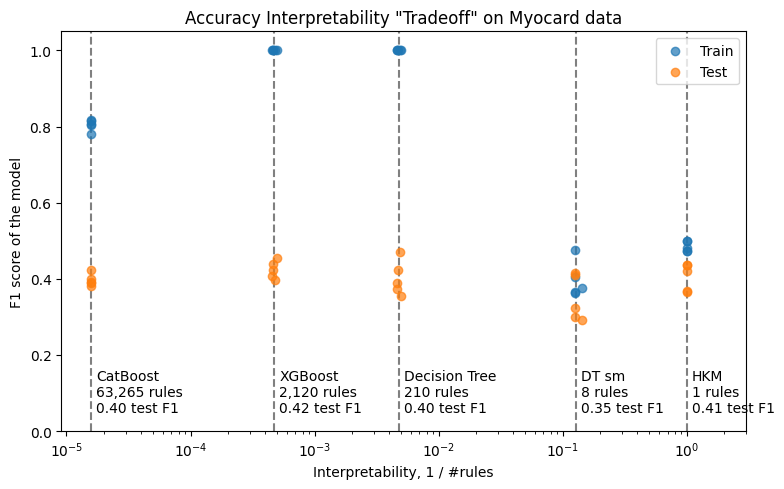

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for ds_part in ['Train', 'Test']:
    y_axis = f'{ds_part} F1 score'
    plt.scatter(1/models_data['#Leaves'], models_data[y_axis], label=ds_part, alpha=0.7)
plt.legend()

avgs = models_data.groupby('model name')['#Leaves'].mean().sort_values()
avg_f1 = models_data.groupby('model name')['Test F1 score'].mean()
for model_name, n_leaves in avgs.items():
    plt.axvline(1/n_leaves, zorder=0, linestyle='--', color='gray',)
    plt.text(1/n_leaves*1.1, 0.05, '\n'.join([model_name, f"{avgs[model_name]:,.0f} rules",
                                              f"{avg_f1[model_name]:.2f} test F1"]))

plt.ylabel('F1 score of the model')
plt.xlabel('Interpretability, 1 / #rules')
plt.xscale('log')
plt.xlim(plt.xlim()[0], 3)

plt.ylim(0, 1.05)


plt.title('Accuracy Interpretability "Tradeoff" on Myocard data')
plt.tight_layout()
#plt.savefig('Acc_Interpret_Tradeoff.pdf')